# Exploratory Data Analysis (EDA) ([#3](https://github.com/molinari135/embryo-project/issues/3))

In this notebook, we perform the following operations:

1. Rename all columns in english
2. Remove all rows that have `NaN` in folder field
3. Remove columns that will not be used
4. Change the label using 0s and 1s instead of strings
5. Convert the original file in `.tsv`

In order to perform all these operations it is **required** do to run the previous notebooks by number convention.

In [8]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from loguru import logger
from embryo_project.config import PROCESSED_DATA_DIR, FIGURES_DIR, ANNOTATIONS_FILE

In [9]:
file_path = Path(ANNOTATIONS_FILE)
df = pd.read_csv(file_path, sep="\t")
df.head()

,folder,label,image
0,D2020.10.07_S00020_I4203_P_WELL01,0,D2020.10.07_S00020_I4203_P_WELL01_RUN361
1,D2020.10.07_S00020_I4203_P_WELL02,0,D2020.10.07_S00020_I4203_P_WELL02_RUN104
2,D2020.10.07_S00020_I4203_P_WELL03,0,D2020.10.07_S00020_I4203_P_WELL03_RUN296
3,D2020.10.07_S00020_I4203_P_WELL04,0,D2020.10.07_S00020_I4203_P_WELL04_RUN198
4,D2020.10.07_S00020_I4203_P_WELL05,0,D2020.10.07_S00020_I4203_P_WELL05_RUN156


label
0    94.064386
1     5.935614
Name: proportion, dtype: float64


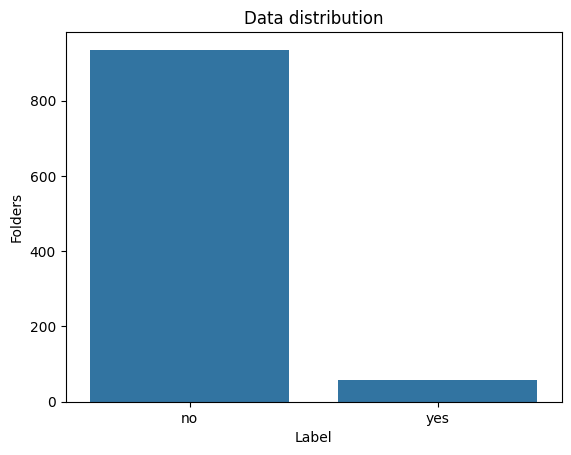

In [10]:
print(df['label'].value_counts(normalize=True) * 100)

sns.countplot(data=df, x='label')
plt.title('Data distribution')
plt.xticks(ticks=[0, 1], labels=['no', 'yes'])
plt.xlabel('Label')
plt.ylabel('Folders')
plt.savefig(FIGURES_DIR / "3a-label-distribution.png")
plt.show()

- `D2020.10.07_S00023_I4203_P_WELL16` was empty in the original dataset
- `D2020.10.28_S00032` does not exists
- `D2021.06.16_S00057` does not exists
- `D2022.09.07_S00152_I4203_P_WELL11` was empty in the original dataset

In [11]:
def extract_run_number(filename):
    match = re.search(r'_RUN(\d+)', filename)
    return int(match.group(1)) if match else -1

label_1_count = 0
label_0_count = 0

for folder_name in df['folder'].unique():
    folder_path = PROCESSED_DATA_DIR / folder_name
    if not folder_path.exists():
        continue

    image_files = sorted(folder_path.glob("*.JPG"), key=lambda x: extract_run_number(x.name))
    if not image_files:
        continue

    folder_df = df[df['folder'] == folder_name]

    # Take all images with label 1, if any
    labeled_1_images = folder_df[folder_df['label'] == 1]['image'].dropna().tolist()
    # Take all images with label 0, if any
    labeled_0_images = folder_df[folder_df['label'] == 0]['image'].dropna().tolist()

    if labeled_1_images:
        min_run = min(extract_run_number(img) for img in labeled_1_images)
        label_type = 1
    elif labeled_0_images:
        min_run = min(extract_run_number(img) for img in labeled_0_images)
        label_type = 0
    else:
        # No label is considered as label 0
        label_0_count += len(image_files)
        continue

    for img in image_files:
        run_num = extract_run_number(img.name)
        if run_num >= min_run:
            if label_type == 1:
                label_1_count += 1
            else:
                label_0_count += 1
        else:
            label_0_count += 1  # Images before the decisive one

print(f"Images with label 1: {label_1_count}")
print(f"Images with label 0: {label_0_count}")

Images with label 1: 312
Images with label 0: 19569
